In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

In [2]:
# Import data
df = pd.read_csv('Mai_Hue.csv')
df.head()

,Timestamp,BG,Insulin Bolus,Noise,Eating
0,06:04,154,0.0,Y,0
1,06:09,147,0.0,Y,0
2,06:14,153,0.0,Y,0
3,06:19,153,8.8,P,120
4,06:24,153,0.0,Y,0


In [3]:
#Make Timestamp into a time series T_values list
from datetime import datetime

# Step 2: Convert the "Timestamp" column to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Calculate the time differences and convert to seconds starting at 0
start_time = df['Timestamp'].iloc[0]
df['TimeInMinutes'] = (df['Timestamp'] - start_time).dt.total_seconds() / 60

# Convert the "TimeInMinutes" column to a list
time_values = df['TimeInMinutes'].tolist()

print(time_values)

[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 41.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 121.0, 125.0, 130.0, 131.0, 135.0, 136.0, 140.0, 141.0, 145.0, 146.0, 152.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 191.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 261.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 351.0, 353.0, 360.0, 365.0, 370.0, 375.0, 380.0, 385.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 420.0, 425.0, 430.0, 435.0, 440.0, 445.0, 450.0, 455.0, 460.0, 465.0, 470.0, 475.0, 480.0, 485.0, 486.0, 490.0, 495.0, 500.0, 505.0, 510.0, 515.0, 520.0, 525.0, 526.0, 530.0, 535.0, 536.0, 540.0, 541.0, 545.0, 550.0, 555.0, 560.0, 565.0, 570.0, 575.0, 580.0, 585.0, 586.0, 590.0, 591.0, 595.0, 596.0, 598.0, 600.0, 605.0, 606.0, 611.0, 616.0, 621.0, 626.0, 631.0, 636.0, 641.0, 645.0, 650.0, 651.0, 655.0,

In [57]:
#Make BG into a list
BG_values = df['BG'].tolist()
#Make Insulin into a list
Insulin_values = df['Insulin Bolus'].tolist()
#Make Eating into a list
Eating_values = df['Eating'].tolist()

#Make Noise into a list that 'N' is replace by 1; 'Y' is replace by 1/2 and 'P' is replace by 0
Noise_values = df['Noise'].tolist()
Noise_values = [1 if x=='N' else x for x in Noise_values]
Noise_values = [1 if x=='Y' else x for x in Noise_values]
Noise_values = [1 if x=='P' else x for x in Noise_values]



In [5]:
def softplus(x):
    return np.log(1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

In [86]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    G1 = y[0]
    G2 = y[1]
    I = y[2]

    try:
        alpha = paras['alpha'].value
        beta1 = paras['beta1'].value
        beta2 = paras['beta2'].value
        I_basal = paras['I_basal'].value
        gamma = paras['gamma'].value
        delta = paras['delta'].value
        I_max = paras['I_max'].value

    except KeyError:
        alpha, beta1, beta2, I_basal, gamma, delta, I_max = paras
    # the model equations
    eating_values = np.interp(t, time_values, Eating_values)
    dG1 = -alpha*G1 + eating_values
    dG2 = alpha*G1 - (beta1 + beta2 * (I+I_basal)) *G2
    # Find the corresponding insulin value for the current time point
    insulin_value = np.interp(t, time_values, Insulin_values)

    dI = gamma * relu(G2 - 180) - delta * I + insulin_value
    return [dG1, dG2, dI]
    #dI = I_max * (reG2**2) / (gamma + reG2**2) - delta * I 
    #dI = I_max + gamma * relu(G2 -  92.5) - delta * I
    #dI = I_max * (G2**2) / (gamma + G2**2) - delta * I 
    #dI = I_max * G2 / (gamma + G2) - delta * I 
    #dI = gamma * G2 - delta * I


def g(t, x0, paras):
    # Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    x = odeint(f, x0, t, args=(paras,))
    return x

def residual(paras, t, data):
    # Compute the residual between actual data and fitted data
    x0 = paras['G10'].value, paras['G20'].value, paras['I0'].value
    model = g(t, x0, paras)

    # Extract the second column of the model (G2)
    x2_model = model[:, 1] 

    # Calculate the weighted residual
    Noise_values_array = np.array(Noise_values)
    weighted_residual = Noise_values_array * (x2_model - data)
    return weighted_residual.ravel()




In [88]:
# initial conditions
G10 = 0
G20 = BG_values[0]
I0 = 0.7
y0 = [G10, G20, I0]


# set parameters including bounds; you can also fix parameters (use vary=False)
# I fixed the initial concentrations, you could also set them as variables if you like (just remove the vary=False in the code below).
params = Parameters()
params.add('G10', value=G10)
params.add('G20', value=G20, vary=False)
params.add('I0', value=I0, vary = False)
params.add('alpha', value=2, min=0.0001)
params.add('beta1', value=0.03, min=0.0001)
params.add('beta2', value=0.02)
params.add('I_basal', value=0.3, min=0.05, max = 20)
params.add('gamma', value=0.2, min=0.0001)
params.add('delta', value=0.3, min=0.0001)
params.add('I_max', value=5, min = 5)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 158
    # variables        = 8
    chi-square         = 250802.050
    reduced chi-square = 1672.01367
    Akaike info crit   = 1180.43223
    Bayesian info crit = 1204.93299
##  Warning: uncertainties could not be estimated:
    I_max:    at initial value
    I_max:    at boundary
[[Variables]]
    G10:     -21.8657767 (init = 0)
    G20:      154 (fixed)
    I0:       0.7 (fixed)
    alpha:    0.27893592 (init = 2)
    beta1:    5.6397e-04 (init = 0.03)
    beta2:    0.00210819 (init = 0.02)
    I_basal:  0.05038800 (init = 0.3)
    gamma:    1.69936958 (init = 0.2)
    delta:    0.31724477 (init = 0.3)
    I_max:    5.00000000 (init = 5)


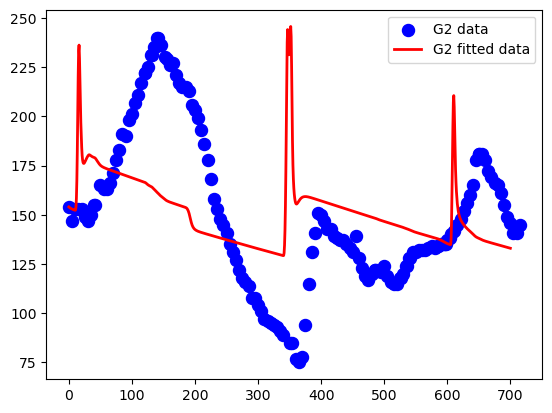

In [89]:
# fit model
result = minimize(residual, params, args=(time_values, BG_values), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., 700., 1000), y0, result.params)

# plot fitted data
plt.figure()
plt.scatter(time_values, BG_values, marker='o', color='b', label='G2 data', s=75)

#plt.plot(np.linspace(0., 700., 1000), data_fitted[:, 0], '-', linewidth=2, color='blue', label='G1 fitted data')
plt.plot(np.linspace(0., 700., 1000), data_fitted[:, 1], '-', linewidth=2, color='red', label='G2 fitted data')
#plt.plot(np.linspace(0., 9., 100), data_fitted[:, 2], '-', linewidth=2, color='green', label='I fitted data')
plt.legend()
#plt.xlim([0, max(t_measured)])
#plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

# display fitted statistics
report_fit(result)

plt.show()